In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt


class Model(object):
    def __init__(self, pars):
        self.pars = pars
        self.mean = self.pars[0]

    def _build_model(self, pars):
        return sps.norm(loc = self.mean, scale = 1.0)

    def samples(self,pars, n = 10):
        return self._build_model(pars).rvs(n)

    def logpdf(self,pars,x):
        return self._build_model(pars).logpdf(x)

    def mle(self,x):
        return x

In [2]:
m = Model(np.array([2.]))


m.logpdf(1.,1)

-1.4189385332046727

In [3]:
1-sps.chi2(1).cdf(1)

0.31731050786291415

In [4]:
x = m.sample(pars = np.array([2.0]), n = int(1e3))
plt.hist(x, bins = 30);

AttributeError: 'Model' object has no attribute 'sample'

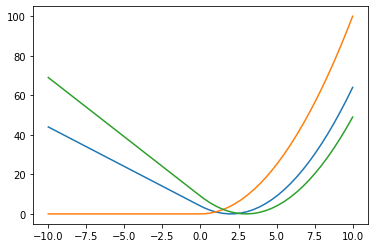

In [210]:
import jax
def teststat(x,mu):
    bestfit = jax.numpy.where(x > 0, x, 0)
    return -2*(jax.scipy.stats.norm.logpdf(x,mu) - jax.scipy.stats.norm.logpdf(x,bestfit))

def get_test_stat(mu):
    return lambda x: jax.vmap(teststat, in_axes=(0,None))(x,mu)

gaussian_lr = jax.vmap(teststat, in_axes=(0,None))


xi = np.linspace(-10,10)
li = get_test_stat(2.0)(xi)
plt.plot(xi,li)
li = get_test_stat(0.0)(xi)
plt.plot(xi,li)
li = get_test_stat(3.0)(xi)
plt.plot(xi,li)



    fjac: array([[1.]])
     fun: array([1.23233333e-09])
 message: 'The solution converged.'
    nfev: 25
     qtf: array([1.23233333e-09])
       r: array([-0.02453933])
  status: 1
 success: True
       x: array([3.8414587])

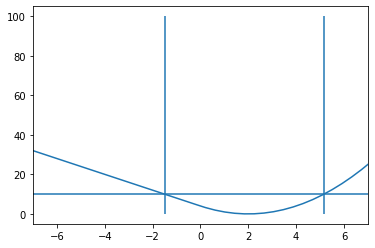

In [275]:
import scipy.optimize

def getcutf(mu):
    def cut(cutval):
        a = scipy.optimize.root(lambda x: get_test_stat(mu)(x) - cutval, mu + 0.1).x
        b = scipy.optimize.root(lambda x: get_test_stat(mu)(x) - cutval, mu - 0.1).x
        li = get_test_stat(mu)(xi)

        right_tail = 1-scipy.stats.norm(mu).cdf(a)
        left_tail = scipy.stats.norm(mu).cdf(b)
        pval = left_tail+right_tail
        return np.array([a,b,pval])
    return cut

a,b,p = getcutf(2.0)(10)
plt.plot(xi,li)
plt.hlines(10,-10,10)
plt.vlines([a,b],0,100)
plt.xlim(-7,7)


scipy.optimize.root(lambda x: getcutf(2.0)(x)[-1]-0.05,10)

In [273]:
def feldman_cousins(mu,level = 0.1):
    r = scipy.optimize.root(lambda x: getcutf(mu)(x)[-1]-level,20)
    return getcutf(mu)(r.x)
fcr = np.array([feldman_cousins(mu) for mu in np.linspace(0.01,6,21)])

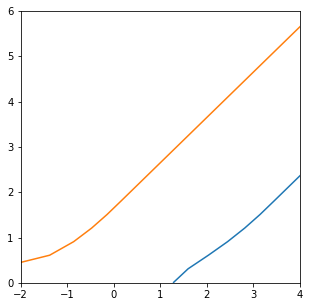

In [274]:
mus = np.linspace(0.01,6,21)
plt.plot(fcr[:,0],mus)
plt.plot(fcr[:,1],mus)
plt.ylim(0,6)
plt.xlim(-2,4)
plt.gcf().set_size_inches(5,5)
plt.savefig('feldman_cousins.png')

0.05 0.95
[ 0.    0.02  0.04 ... 19.96 19.98 20.  ] hypos
[[ 1.  6.]
 [ 1.  6.]
 [ 1.  6.]
 ...
 [15. 31.]
 [15. 31.]
 [15. 31.]]
[0.0000,4.7400]


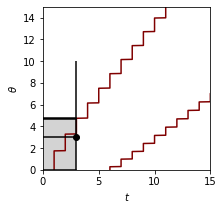

In [303]:
def acceptance_region(td,lo_p,hi_p):
    return [td.ppf(lo_p) if lo_p > 0 else -100,td.ppf(hi_p) if hi_p < 1 else 100]

def plot_gaussian(data = 5, fname = 'plot.png', plot_mle=False, plot_data=False, plot_interval = False, interval = 'upper', alpha = 0.1):
    hypos  = np.linspace(0,20,1001)
    dspace = np.linspace(-5,5,101)
    h0_dists = [sps.norm(mu,1) for mu in hypos] # for flip-flopping plots
    h0_dists = [sps.poisson(mu+3) for mu in hypos]  #for F-C-step plots

    if interval=='upper':
        lo_p,hi_p = alpha,1
    # elif interval=='central':
    #   lo_p,hi_p = 0.025,0.975
    elif interval=='central':
        lo_p,hi_p = alpha/2,1-alpha/2

    print(lo_p,hi_p)
    print(hypos,'hypos')

    def acceptance_region(td,lo_p,hi_p):
        return [td.ppf(lo_p) if lo_p > 0 else -100,td.ppf(hi_p) if hi_p < 1 else 100]

    band = np.array([acceptance_region(td,lo_p,hi_p) for td in h0_dists])
    print(band)

    upper,lower = band[:,0],band[:,1]
    plt.plot(lower,hypos, c = 'maroon')
    plt.plot(upper,hypos, c = 'maroon')
    # plt.plot([lower,upper],np.stack([hypos,hypos]), c = 'grey', linestyle='dashed');

    int_upper = np.interp(data,upper,hypos)
    int_lower = np.interp(data,lower,hypos)
    print(f'[{int_lower:.4f},{int_upper:.4f}]')

    mle = data
    if plot_mle:
        plt.hlines(mle,-5,data, colors='k')
        plt.scatter(data,mle,c = 'k', zorder=100, linewidths=1)
    if plot_data:
        plt.vlines(data,0,10, colors = 'k')
    if plot_interval:
        plt.hlines(int_lower,-5,data, colors='k', linewidths = 2.5)
        plt.hlines(int_upper,-5,data, colors='k', linewidths = 2.5)
        plt.fill_between([-5,data],np.ones(2)*int_lower,np.ones(2)*int_upper, facecolor = 'lightgray')
    plt.xlim(0,15)
    plt.ylim(0,15)
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\theta$')
    plt.gcf().set_size_inches(3,3)
    plt.savefig(fname, dpi=600)

plot_gaussian(data = 3, fname = f'gaussian_twosided_2.png', plot_data = True, plot_mle = True, plot_interval=True, interval='central')

In [302]:
acceptance_region(sps.poisson(mu = 5.5),0.05,0.95);


[2.0, 10.0]

In [169]:
hypos   = np.linspace(0,5,11)
xi      = np.linspace(-10,10)
bestfit = 0.0

dh = np.array([np.random.normal(h,size = (100000,)) for h in hypos])

def tstat(bestfit):
    pass

# lrt_vals = np.array([sps.norm.logpdf(d,h)-sps.norm.logpdf(d,bestfit) for d,h in zip(dh,hypos)])
# plt.contourf(lrt_vals)

In [166]:
sum([sps.poisson(5+3).pmf(x) for x in np.arange(4,13)])

0.8938226912717524

In [167]:
sps.poisson(5+3).ppf(0.05),sps.poisson(5+3).ppf(0.95)

(4.0, 13.0)

In [159]:
a = (np.array([sps.poisson(5+3).cdf(x) for x in np.arange(25)]) > 0.025).tolist()
print(a)
a.index(True)

[False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


3

In [157]:
a = (np.array([sps.poisson(5+3).cdf(x) for x in np.arange(25)])).tolist()
# a.index(True)
a

[0.0003354626279025119,
 0.003019163651122605,
 0.013753967744002971,
 0.04238011199168396,
 0.09963240048704596,
 0.19123606207962532,
 0.31337427753639774,
 0.4529608094869946,
 0.5925473414375915,
 0.716624258727011,
 0.8158857925585467,
 0.8880759989814815,
 0.9362028032634382,
 0.9658192982061807,
 0.9827430096020336,
 0.9917689890131551,
 0.9962819787187159,
 0.9984057385801562,
 0.9993496318519075,
 0.9997470605979081,
 0.9999060320963082,
 0.9999665926671274,
 0.9999886146928798,
 0.9999962745279242,
 0.9999988278062723]

In [128]:
sps.poisson(5+3).cdf3)

SyntaxError: invalid syntax (2923329075.py, line 1)

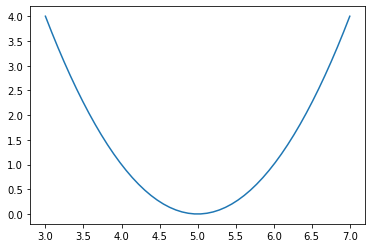

In [58]:
import jax.scipy as jsp
import jax
th = np.linspace(3,7)
lh = -2*(jax.vmap(jsp.stats.norm.logpdf, in_axes=(None,0))(5,th) - jsp.stats.norm.logpdf(5,5))
plt.plot(th,lh)

In [60]:
np.interp(6,th,lh)

1.001249492168427